## Group Project 509 ,  Hoori Javadnia & Fatemeh Khosravi

### descriptive statistics 

In [1]:
#!pip install --upgrade emoji
#!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=5614fe176293f08405987f0c276b4d77203c41e1bf7bba4e33b950cec1bdcf3b
  Stored in directory: /Users/fatemehkhosravi/Library/Caches/pip/wheels/8d/f5/02/63dc849dcc2c6d417626fd8440f2fc9da91c2f12afbe65c790
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.2.0
    Uninstalling emoji-2.2.0:
      Successfully uninstalled emoji-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import csv
import time
import random
from collections import OrderedDict
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import nltk
import random


py.init_notebook_mode(connected=True)


from nltk.stem import WordNetLemmatizer
from random import randint
#from textblob import TextBlob
from time import sleep

color = sns.color_palette()
%matplotlib inline


from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix
import plotly.io as pio

color = sns.color_palette()
%matplotlib inline
import emoji
from nltk.tokenize import word_tokenize
import re
re.compile('<title>(.*)</title>')

import nltk
nltk.download('stopwords')

import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

import re
re.compile('<title>(.*)</title>')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fatemehkhosravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


re.compile(r'<title>(.*)</title>', re.UNICODE)

## Read the data 

In [1]:
import pandas as pd
data = pd.read_csv('/Users/fatemehkhosravi/Desktop/cus_q_dataset_final.csv')

In [2]:
print(data.shape)
data.head(10)

(40267, 2)


,Query,Class
0,\r\n\r\nWhat is the PDF document stating my fi...,Billing
1,\r\n\r\nI noticed that I was charged an additi...,Billing
2,\r\n\r\nI charged 83.00 a payment on my card b...,Billing
3,\r\n\r\nWhat address should I use to send this...,Billing
4,\r\n\r\nI noticed an pending charge on my cell...,Billing
5,"\r\n\r\nHi there, I noticed on my last stateme...",Billing
6,\r\n\r\nHas my credit card payment of \$50 bee...,Billing
7,\r\n\r\nI typically pay my bill within busines...,Billing
8,\r\n\r\nWere curious what billing plan of ours...,Billing
9,\r\n\r\nCan you please clarify the amount I am...,Billing


In [3]:
#Summary of the dataset
data.describe()

,Query,Class
count,40265,40267
unique,39790,4
top,\r\n\r\nWhat is the process for returning an i...,Billing
freq,16,10069


In [6]:
data['Class'].value_counts()

Billing            10069
Product Inquiry    10067
Returns            10066
Tech. Support      10065
Name: Class, dtype: int64

<AxesSubplot:xlabel='Class'>

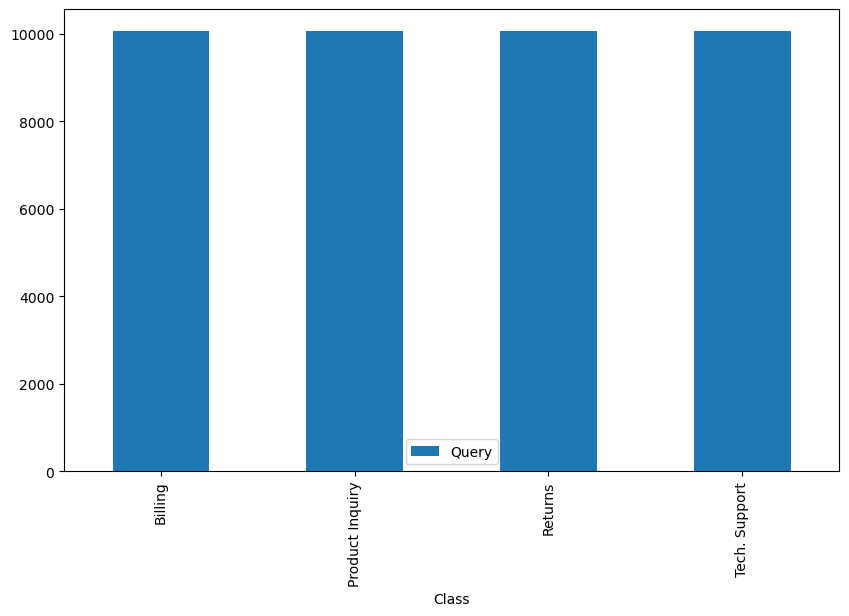

In [8]:
%matplotlib inline
data.groupby('Class').agg({'Query': 'count'}).plot.bar(figsize=(10,6))

In [9]:
data.columns

Index(['Query', 'Class'], dtype='object')

In [12]:
# Stopwords
sw = stopwords.words("english")

# Some punctuation variations
punct = list(set(punctuation))
punct.append(",")
punct = "".join(punct)
tw_punct = list(set(punct) - set(["#"]))
tw_punct = "".join(tw_punct)

In [13]:


# Global text prep pipeline function
def prepare(text, pipeline): 
    tokens = str(text)

    for transform in pipeline: 
        tokens = transform(tokens)
        
    return(tokens)
    
# Remove Punctuation Function
def remove_punctuation(text): 
    text = text.translate(str.maketrans("", "", tw_punct))
    return text

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Remove White Spaces Function
def remove_whitespace(text):
    text = whitespace_pattern.sub(r" ", text)
    return text

def tokenize(text):  
    tokens = text.split(" ")
    # Remove empty splits
    tokens = [x for x in tokens if x != ""]
    return tokens

def remove_stop(tokens):
    tokens = [x for x in tokens if not x in sw]
    return tokens



def descriptive_stats(df_col, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Initialize blank counter
    token_counter = Counter()
    # Update counter row by row with token column
    df_col.map(token_counter.update)
    
    num_tokens = sum(token_counter.values())
    num_unique_tokens = len(token_counter)
    lexical_diversity = num_unique_tokens / num_tokens

    num_characters = 0
    for k,v in token_counter.items():
        token_length = len(k) * v
        num_characters += token_length

    top_tokens = token_counter.most_common(5)
    # Convert top 5 tokens to dataframe
    top_token_df = pd.DataFrame(top_tokens, columns = ["Token", "Frequency"])
    
    if verbose == True:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print("The top five most common tokens are:")
        print(top_token_df)
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [14]:
# Apply Processing Pipeline
prep_pipeline = [str.lower, remove_punctuation, 
                   remove_whitespace, tokenize, 
                   remove_stop]

data["tokens"] = data["Query"].apply(
    prepare, pipeline = prep_pipeline
)


In [15]:
data.head()

,Query,Class,tokens
0,\r\n\r\nWhat is the PDF document stating my fi...,Billing,"[pdf, document, stating, final, transaction, b..."
1,\r\n\r\nI noticed that I was charged an additi...,Billing,"[noticed, charged, additional, fee, even, thou..."
2,\r\n\r\nI charged 83.00 a payment on my card b...,Billing,"[charged, 8300, payment, card, still, seen, cr..."
3,\r\n\r\nWhat address should I use to send this...,Billing,"[address, use, send, customers, invoice, recen..."
4,\r\n\r\nI noticed an pending charge on my cell...,Billing,"[noticed, pending, charge, cellular, phone, bi..."


In [16]:
data["num_tokens"] = data["tokens"].map(len)

In [17]:
print("Descriptive Stats:\n")
print(descriptive_stats(data["tokens"]))


Descriptive Stats:

There are 364409 tokens in the data.
There are 21031 unique tokens in the data.
There are 2295525 characters in the data.
The lexical diversity is 0.058 in the data.
The top five most common tokens are:
       Token  Frequency
0     return       8343
1    product       6412
2       item       5398
3  purchased       4106
4    payment       3736
[364409, 21031, 0.057712625099819156, 2295525]


In [ ]:
# Save the preprocessed data to a new CSV file
#data.to_csv('preprocessed_data.csv', index=False)